# Calibration of a line

Simple demo demonstrating the workflow of `rxmc`.

In [1]:
import rxmc

Using database version X4-2024-12-31 located in: /home/beyerk/db/exfor/unpack_exfor-2024/X4-2024-12-31


In [2]:
from collections import OrderedDict
import corner
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats

In [3]:
rng = np.random.default_rng(49)

## define parameters

In [4]:
help(rxmc.params.Parameter)

Help on class Parameter in module rxmc.params:

class Parameter(builtins.object)
 |  Parameter(name, dtype=<class 'float'>, unit='', latex_name=None, bounds=(-inf, inf))
 |  
 |  Methods defined here:
 |  
 |  __eq__(self, other)
 |      Return self==value.
 |  
 |  __init__(self, name, dtype=<class 'float'>, unit='', latex_name=None, bounds=(-inf, inf))
 |      Parameters:
 |          name (str): Name of the parameter
 |          dtype (np.dtype): Data type of the parameter
 |          unit (str): Unit of the parameter
 |          latex_name (str): LaTeX representation of the parameter
 |          bounds (tuple, optional): Bounds for the parameter as a tuple (min, max)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables
 |  
 |  __weakref__
 |      list of weak references to the object
 |  
 |  ----------------------------------------------------------------------

## make the model

In [5]:
help(rxmc.physical_model.PhysicalModel)

Help on class PhysicalModel in module rxmc.physical_model:

class PhysicalModel(builtins.object)
 |  PhysicalModel(params: list[rxmc.params.Parameter])
 |  
 |  Represents an arbitrary parameteric model $y_{model}(x;params)$, for
 |  comparison to some experimental measurement $\{x_i, y(x_i)\}$ contained
 |  in an Observation object
 |  
 |  Methods defined here:
 |  
 |  __call__(self, observation: rxmc.observation.Observation, *params) -> numpy.ndarray
 |      Call self as a function.
 |  
 |  __init__(self, params: list[rxmc.params.Parameter])
 |      Initialize the PhysicalModel with a list of parameters.
 |      Parameters:
 |      ----------
 |      params: list[Parameter]
 |          A list of Parameter objects that define the model's parameters.
 |          Each Parameter should have a name and a dtype.
 |  
 |  evaluate(self, observation: rxmc.observation.Observation, *params) -> numpy.ndarray
 |      Evaluate the model at the given parameter values.
 |      Should be overridd

# Clearly to make a model, we need to understand these things called `Observation`s. 

This is an important detail, the whole point of `rxmc` is to compare predictions of a `PhysicalModel` to data contained in an `Observation`, to calibrate the parameters of the `PhysicalModel`.

In [6]:
help(rxmc.observation.Observation)

Help on class Observation in module rxmc.observation:

class Observation(builtins.object)
 |  Observation(x: numpy.ndarray, y: numpy.ndarray, y_stat_err=None, y_sys_err_normalization=None, y_sys_err_normalization_mask=None, y_sys_err_offset=None, y_sys_err_offset_mask=None)
 |  
 |  A class to represent an observation with statistical errors,
 |  as well as systematic errors associated with a common normalization
 |  and offset of all or some of the data points of the the dependent
 |  variable y.
 |  
 |  Attributes:
 |  ----------
 |  x : np.ndarray
 |      The independent variable data.
 |  y : np.ndarray
 |      The dependent variable data.
 |  statistical_covariance : np.ndarray
 |      The covariance matrix representing the statistical errors of y.
 |  systematic_offset_covariance : np.ndarray
 |      The covariance matrix representing systematic errors associated with
 |      the offset of y.
 |  systematic_normalization_covariance : np.ndarray
 |      The fractional covariance 

Ok, so basically it's just some `x` and `y`, ans some information about the errors of `y`. We can think of `Observation`s like experimental measurements of an observable, and we want to build a model to make uncertainty-quantified predictions of that observable.

In [7]:
class LinearModel(rxmc.physical_model.PhysicalModel):
    def __init__(self):
        params = [
            rxmc.params.Parameter("m", float, "no-units"),
            rxmc.params.Parameter("b", float, "y-units"),
        ]
        super().__init__(params)

    def evaluate(self, observation, m, b):
        return self.y(observation.x, m, b)

    def y(self, x, m, b):
        # useful to have a function hat takes in an array-like x
        # rather than an Observation, e.g. for plotting
        return m * x + b

Well that's not too complicated.

In [8]:
my_model = LinearModel()

Let's test it out:

In [9]:
# true params are obviously m = 1, b = 0
observation = rxmc.observation.Observation(x=np.array([1, 2, 3]), y=np.array([1, 2, 3]))
my_model(observation, 1, 0)

array([1, 2, 3])

In [10]:
my_model.y(observation.x, 2, 1)

array([3, 5, 7])

In [11]:
# now with parameters that are obviously wrong
my_model(observation, 2, 1)

array([3, 5, 7])

In [12]:
# just to show some ways that may be convenient to pass around params
# note they must be in the same order as in my_model.evaluate,
# which should be in the same order as my_model.params

p = [2, 1]
print(my_model(observation, *p))
p = np.array([2, 1])
print(my_model(observation, *p))

[3 5 7]
[3 5 7]


## define a prior

Let's imagine this line corresponds to some physics, and we have some backround knowledge to inform us what we expect $m$ and $b$ to be. We can encode that into a prior distribution:

In [13]:
prior_mean = OrderedDict(
    [
        ("m", 1),
        ("b", 1),
    ]
)
prior_std_dev = OrderedDict(
    [
        ("m", 1),
        ("b", 1),
    ]
)

In [14]:
covariance = np.diag(list(prior_std_dev.values())) ** 2
mean = np.array(list(prior_mean.values()))

In [15]:
n_prior_samples = 1000
prior_distribution = stats.multivariate_normal(mean, covariance)
prior_samples = prior_distribution.rvs(size=n_prior_samples, random_state=rng)

Let's plot some samples of lines from this prior

In [16]:
x = np.linspace(0, 1, 10)

# array to hold the lines
y = np.zeros((n_prior_samples, len(x)))

# propagate the prior through to the observation
for i in range(n_prior_samples):
    sample = prior_samples[i, :]
    y[i, :] = my_model.y(x, *sample)

# grab confidence intervals for plotting
upper, lower = np.percentile(y, [5, 95], axis=0)

Text(0.5, 1.0, 'prior')

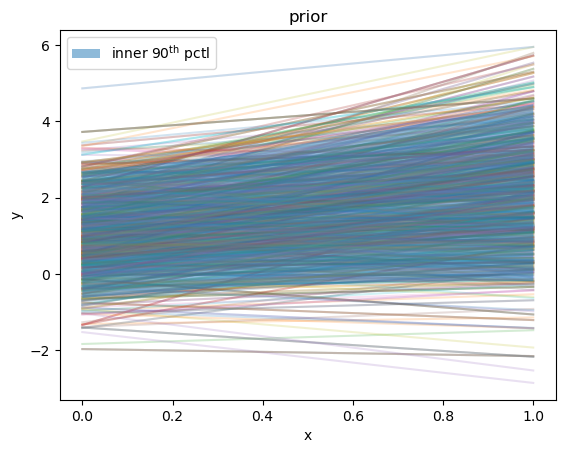

In [17]:
for i in np.random.choice(n_prior_samples, 1000):
    plt.plot(x, y[i, :], zorder=1, alpha=0.2)
    # pass

plt.fill_between(
    x, lower, upper, alpha=0.5, zorder=2, label=r"inner 90$^\text{th}$ pctl"
)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("prior")

Text(0.5, 0.98, 'prior')

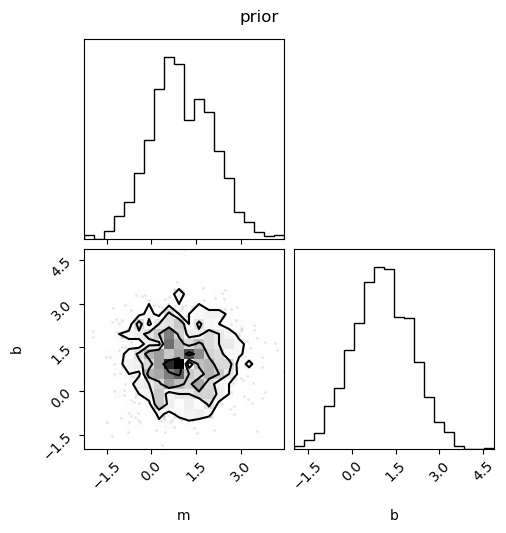

In [18]:
fig = corner.corner(prior_samples, labels=[p.name for p in my_model.params])
fig.suptitle("prior")

## Now let's update our prior by comparing to some data

This will require learning about `LikelihoodModel`s in `rxmc`. These encode our assumptions about the error on an experimental `Observation`, and are a necessary ingredient for comparing to the predictions of a `PhysicalModel`.

In our case we will mock experimental data by synthetically generate some data with noise about a "true" $m$ and $b$. Our calibration posterior should converge to be centered about this true point.

Let us assume that the experimentalists made a perfect estimate of the experimental noise in their setup. That is, the error bars they report will correspond exactly to the true distribution from which we sample.

This noise will correspond to statistical noise. Later on we will look at systematic experimental error.

In [19]:
true_params = OrderedDict(
    [
        ("m", 0.6),
        ("b", 2),
    ]
)

x = np.linspace(0, 1, 10)
noise = 0.1
y_exp = my_model.y(x, *list(true_params.values())) + rng.normal(
    scale=noise, size=len(x)
)
y_stat_err = noise * np.ones_like(y_exp)  # noise is just a constant fraction of y
obs1 = rxmc.observation.Observation(x=x, y=y_exp, y_stat_err=y_stat_err)

Text(0.5, 1.0, 'experimental constraint')

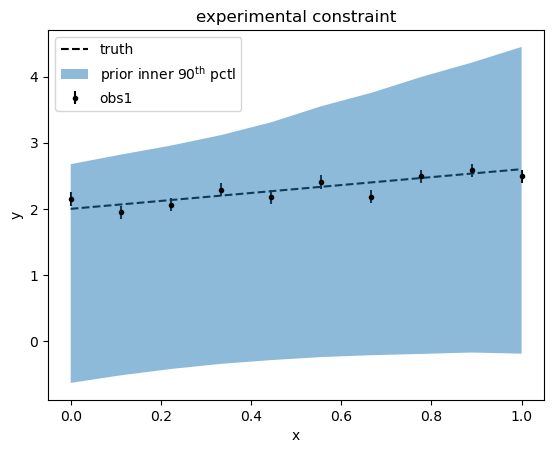

In [20]:
plt.errorbar(
    x,
    y_exp,
    y_stat_err,
    color="k",
    marker=".",
    linestyle="none",
    label="obs1",
)
plt.plot(x, my_model.y(x, *list(true_params.values())), "k--", label="truth")
plt.xlabel("x")
plt.ylabel("y")

plt.fill_between(
    x,
    lower,
    upper,
    alpha=0.5,
    zorder=2,
    label=r"prior inner 90$^\text{th}$ pctl",
)

plt.legend()
plt.title("experimental constraint")

Clearly, our prior is at odds with our observation. We will now determine a posterior distribution of $m$ and $b$ that takes `obs1` into account. To do this, we will need to think about a `LikelihoodModel` for `obs1`.

## set up `LikelihoodModel` and `Constraint`.

We will use the simplest assumption about the error on y: that the experimentalists exactly reported the statistical error, and there is no systematic error at all. This implies that each data point in `obs1.y`, say `obs1.y[i]` can be modeled as being an random variate, each sampled independently from normal distributions with mean `obs1.y[i]` and with standard deviation `obs1.y_stat_err[i]`.

This behavior is handled by the default `LikelihoodModel`:

In [21]:
help(rxmc.likelihood_model.LikelihoodModel)

Help on class LikelihoodModel in module rxmc.likelihood_model:

class LikelihoodModel(builtins.object)
 |  LikelihoodModel(frac_err: float = 0.0, divide_by_N: bool = False, covariance_scale: float = 1.0)
 |  
 |  A class to represent a likelihood model for comparing an Observation
 |  to a PhysicalModel.
 |  
 |  The default behavior uses the following covariance matrix:
 |      \[
 |          \Sigma_{ij} = \sigma^2_{i}^{stat} \delta_{ij}
 |                      + \Sigma_{ij}^{sys}
 |                      + \gamma^2 y_m^2(x_i, lpha)
 |      \]
 |  where $sigma^2_{i}^{stat}$ is the statistical variance of the i-th
 |  observation, (`observation.statistical_covariance`) and $\gamma$ is the
 |  fractional uncorrelated error (`self.frac_err`).
 |  
 |  Here, $Sigma_{ij}^{sys}$ is the systematic covariance matrix:
 |      \[
 |          \Sigma_{ij}^{sys} = \eta**2 y_m(x_i, lpha) y_m(x_j, lpha) + \omega,
 |      \]
 |  where $\eta$ is the uncertainty in the overall normalization of the
 |

Sorry, I know that's a lot to read. The important piece is right here:

 |  Note that if there is no systematic uncertainty encoded in the `observation`
 |  and `self.fractional_uncorrelated_error` takes the default value of 0, the
 |  covariance matrix becomes diaginal, and the `chi2` function reduces to the
 |  simple and familiar $\chi^2$ form.

This means that, in our case in which the errors are only statistical, the likelihood will be porportional to the familiar form:

\begin{equation}
 \mathcal{L}(\alpha|y) \propto e^{ - \chi^2(\alpha,y) }
\end{equation}

where the Chi-squared is simply

\begin{equation}
\chi^2(\alpha,y) = \sum_i \frac{(y(x_i) - y_m(x_i;\alpha) )^2}{\sigma^2_i}
\end{equation}

In a later tutorial we will use more complicated `Observation`s that include systematic error, and look at other `LikelihoodModel`s.

In [22]:
likelihood_model = rxmc.likelihood_model.LikelihoodModel()

In [23]:
constraint = rxmc.constraint.Constraint(
    [obs1],
    my_model,
    likelihood_model,
)

Let's test this `constraint` thing out. What is the reduced $\chi^2$ for the prior mean?

In [24]:
constraint.chi2(prior_distribution.mean) / constraint.n_data_pts

np.float64(64.18631209285812)

Here is proof that, in this case, we reduce to the form described above:

In [25]:
y = my_model(obs1, *prior_distribution.mean)
np.sum((y - obs1.y) ** 2 / y_stat_err**2) / constraint.n_data_pts

np.float64(64.18631209285807)

## running the calibration

In [26]:
help(rxmc.walker.Walker)

Help on class Walker in module rxmc.walker:

class Walker(builtins.object)
 |  Walker(model_sample_conf: rxmc.param_sampling.SamplingConfig, evidence: rxmc.evidence.Evidence, likelihood_sample_confs: list[rxmc.param_sampling.SamplingConfig] = [], rng: numpy.random._generator.Generator = Generator(PCG64) at 0x70DCA58C3300)
 |  
 |  A class that encapsulates the sampling configuration for a Bayesian
 |  inference problem, including the physical model and likelihood model
 |  configurations. It manages the sampling process for both the physical model
 |  and the likelihood model parameters, alternating between each model in
 |  a Gibbs sampling framework.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, model_sample_conf: rxmc.param_sampling.SamplingConfig, evidence: rxmc.evidence.Evidence, likelihood_sample_confs: list[rxmc.param_sampling.SamplingConfig] = [], rng: numpy.random._generator.Generator = Generator(PCG64) at 0x70DCA58C3300)
 |      Initialize the SamplingConfig with a l

First we need to put together our `Evidence`. With one constraint this seems trivial, but this will be useful down the road when we may want to combine multiple constraints together.

In [27]:
evidence = rxmc.evidence.Evidence([constraint])

Another chore we have to do is configure how we will sample our parameter space.

In [28]:
help(rxmc.param_sampling.MetropolisHastingsSampler)

Help on class MetropolisHastingsSampler in module rxmc.param_sampling:

class MetropolisHastingsSampler(SamplingConfig)
 |  MetropolisHastingsSampler(params: list[rxmc.params.Parameter], prior, starting_location: numpy.ndarray, proposal: rxmc.proposal.ProposalDistribution)
 |  
 |  Metropolis-Hastings sampler for MCMC.
 |  
 |  Method resolution order:
 |      MetropolisHastingsSampler
 |      SamplingConfig
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, params: list[rxmc.params.Parameter], prior, starting_location: numpy.ndarray, proposal: rxmc.proposal.ProposalDistribution)
 |      Initializes the Metropolis-Hastings sampler with the provided parameters.
 |      
 |      Parameters:
 |      ----------
 |      proposal: proposal.ProposalDistribution
 |          Proposal distribution object that has a method `__call__` which
 |          takes in a parameter vector and an rng, returning a proposed
 |          parameter vector.
 |  
 |  -------------------

This means we have to decide on a proposal distribution. We will use a simple form: just sampling from a scaled down version of the prior about the previos point:

In [29]:
def proposal_distribution(x, rng):
    return stats.multivariate_normal.rvs(
        mean=x, cov=prior_distribution.cov / 100, random_state=rng
    )

In [30]:
sampling_config = rxmc.param_sampling.MetropolisHastingsSampler(
    params=my_model.params,
    starting_location=prior_distribution.mean,
    proposal=proposal_distribution,
    prior=prior_distribution,
)

In [31]:
walker = rxmc.walker.Walker(
    sampling_config,
    evidence,
)

In [32]:
%%time
walker.walk(
    n_steps=20000,
    burnin=1000,
)

Burn-in batch 1/1 completed, 1000 steps.
Batch: 1/1 completed, 20000 steps. 
  Model parameter acceptance fraction: 0.273
CPU times: user 6.32 s, sys: 11.2 ms, total: 6.33 s
Wall time: 6.33 s


0.27305

In [33]:
walker.model_chain.shape

(20000, 2)

In [35]:
chain = walker.model_chain
logl = walker.log_posterior_record

Text(0.5, 0, '$i$')

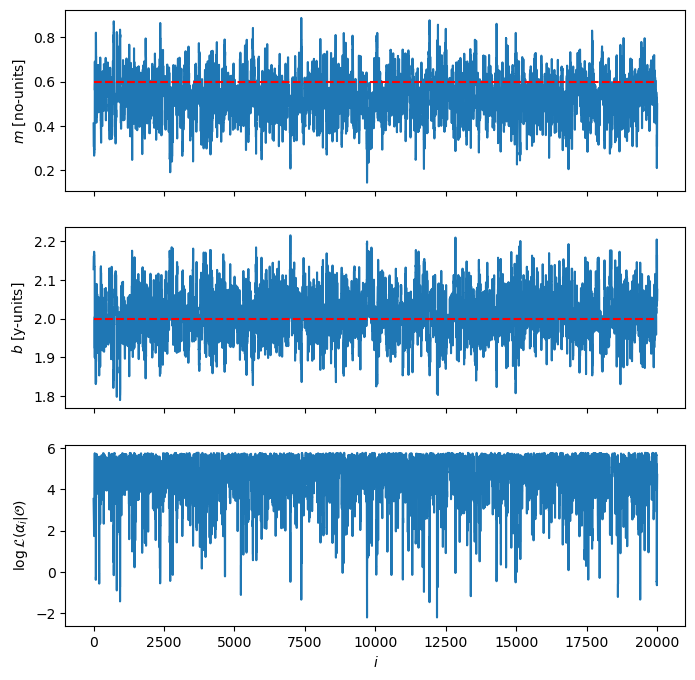

In [36]:
fig, axes = plt.subplots(chain.shape[1] + 1, 1, figsize=(8, 8), sharex=True)
for i in range(chain.shape[1]):
    axes[i].plot(chain[:, i])
    axes[i].set_ylabel(f"${my_model.params[i].latex_name}$ [{my_model.params[i].unit}]")
    true_value = true_params[my_model.params[i].name]
    axes[i].hlines(true_value, 0, len(chain), "r", linestyle="--")


axes[-1].plot(logl)
axes[-1].set_ylabel(r"$\log{\mathcal{L}(\alpha_i | \mathcal{O})}$")

axes[-1].set_xlabel(r"$i$")
# plt.legend(title="chains", ncol=3,)

In [37]:
posterior_range = np.vstack([np.min(chain, axis=0), np.max(chain, axis=0)]).T

Text(0.5, 0.98, 'posterior')

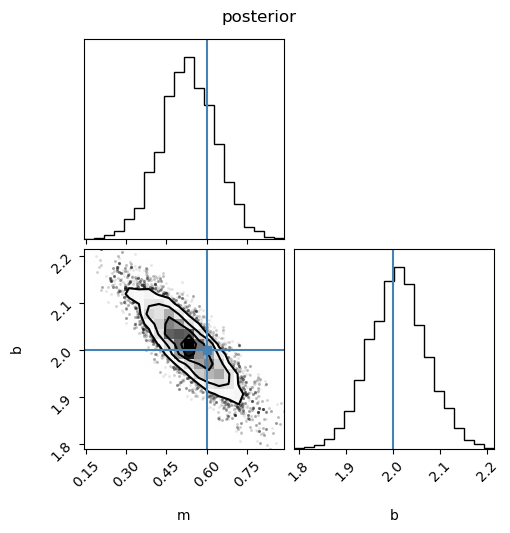

In [38]:
fig = corner.corner(
    chain,
    labels=[p.name for p in my_model.params],
    label="posterior",
    truths=[true_params["m"], true_params["b"]],
)
fig.suptitle("posterior")

In [39]:
x_full = np.linspace(-1, 2, 10)

In [40]:
n_posterior_samples = chain.shape[0]
y = np.zeros((n_posterior_samples, len(x_full)))
for i in range(n_posterior_samples):
    sample = chain[i, :]
    y[i, :] = my_model.y(x_full, *sample)

upper, median, lower = np.percentile(y, [5, 50, 95], axis=0)

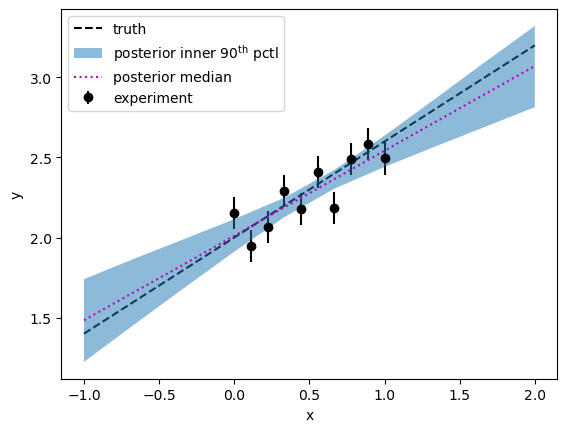

In [41]:
plt.plot(x_full, my_model.y(x_full, *list(true_params.values())), "k--", label="truth")
plt.xlabel("x")
plt.ylabel("y")
plt.errorbar(
    x,
    obs1.y,
    y_stat_err,
    color="k",
    marker="o",
    linestyle="none",
    label="experiment",
)
plt.fill_between(
    x_full,
    lower,
    upper,
    alpha=0.5,
    zorder=2,
    label=r"posterior inner 90$^\text{th}$ pctl",
)
plt.plot(x_full, median, "m:", label="posterior median")

plt.legend()
# plt.title("predictive posterior")

# Nice!

Hopefully this simple example served to illustrate the basic function of the working pieces of `rxmc`. The true power is the ability to compose different `Constraint`s, and easily manage and test different model forms for both the `PhysicalModel` and `LikelihoodModel`. 


Check out the other demos to see how `rxmc` helps us handle more realistic problems.